In [96]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Flatten, Dense, LSTM, Reshape
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# load data
data = pd.read_excel(os.path.join('..', 'data', 'raw', 'market_data.xlsx'), usecols=['Date', 'CPI', 'PE', 'M2', '_MKT'])
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# preprocess
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
scaled_data = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

display(scaled_data)

,PE,M2,CPI,_MKT
Date,,,,
1988-04-10,0.095785,0.303164,0.629228,0.001175
1988-04-17,0.076628,0.309296,0.611069,0.000463
1988-04-24,0.076628,0.309296,0.611069,0.000465
1988-05-01,0.080460,0.309296,0.611069,0.000606
1988-05-08,0.072797,0.309296,0.611069,0.000296
...,...,...,...,...
2024-04-07,0.620690,0.134544,0.534995,0.990466
2024-04-14,0.605364,0.158827,0.455907,0.974132
2024-04-21,0.578544,0.158827,0.455907,0.943699


In [97]:
def create_lagged_dataset(data, lag):
    X, y = [], []
    for i in range(len(data) - lag):
        X.append(data.iloc[i:(i + lag)].values)
        y.append(data.iloc[i + lag]['_MKT'])
    return np.array(X), np.array(y)

# lagged dataset
lag = 4 # use prev 4 week data to predict (approx. 1 month)
X, y = create_lagged_dataset(scaled_data, lag=lag)

# time-based split (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f'Training data shape: {X_train.shape}')
print(f'Testing data shape: {X_test.shape}')

# input shape
input_shape = (X.shape[1], X.shape[2])

Training data shape: (1503, 4, 4)
Testing data shape: (376, 4, 4)


In [109]:
# build
inputs = Input(shape=input_shape)
x = Conv1D(filters=8, kernel_size=2, activation='relu')(inputs)
x = Conv1D(filters=16, kernel_size=2, activation='relu')(x)
x = Conv1D(filters=32, kernel_size=2, activation='relu')(x)
x = Flatten()(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dense(16, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dense(8, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Reshape((8, 1))(x)
x = LSTM(50, return_sequences=True)(x)
x = LSTM(50)(x)
outputs = Dense(1)(x)

# compile
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mse')

# output summary
model.summary()

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 4, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_48 (Conv1D)              │ (None, 3, 8)           │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_49 (Conv1D)              │ (None, 2, 16)          │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_50 (Conv1D)              │ (None, 1, 32)          │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_16 (Reshape)            │ (None, 8, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ (None, 8, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_33 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,771 (131.92 KB)

 Trainable params: 33,771 (131.92 KB)

 Non-trainable params: 0 (0.00 B)

In [110]:
# early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# train
history = model.fit(X_train, y_train, epochs=150, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/150


47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.5962 - val_loss: 0.7053
Epoch 2/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3889 - val_loss: 0.5244
Epoch 3/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2492 - val_loss: 0.3036
Epoch 4/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1571 - val_loss: 0.2103
Epoch 5/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0992 - val_loss: 0.1731
Epoch 6/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0624 - val_loss: 0.1283
Epoch 7/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0391 - val_loss: 0.0952
Epoch 8/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0245 - val_loss: 0.0643
Epoch 9/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0158 - val_loss: 0.0536
Epoch 10/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0102 - val_loss: 0.0589
Epoch 11/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069 - val_loss: 0.0579
Epoch 12/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0047 - val

In [111]:
# predict
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# evaluate model
is_mse = mean_squared_error(y_train, train_predictions)
is_rmse = np.sqrt(is_mse)
is_mae = mean_absolute_error(y_train, train_predictions)
is_mape = mean_absolute_percentage_error(y_train, train_predictions)
is_r2 = r2_score(y_train, train_predictions)
os_mse = mean_squared_error(y_test, test_predictions)
os_rmse = np.sqrt(os_mse)
os_mae = mean_absolute_error(y_test, test_predictions)
os_mape = mean_absolute_percentage_error(y_test, test_predictions)
os_r2 = r2_score(y_test, test_predictions)

print(f'In-Sample MSE: {is_mse}')
print(f'Out-of-Sample MSE: {os_mse}')
print(f'In-Sample RMSE: {is_rmse}')
print(f'Out-of-Sample RMSE: {os_rmse}')
print(f'In-Sample MAE: {is_mae}')
print(f'Out-of-Sample MAE: {os_mae}')
print(f'In-Sample MAPE: {is_mape}')
print(f'Out-of-Sample MAPE: {os_mape}')
print(f'In-Sample R2: {is_r2}')
print(f'Out-of-Sample R2: {os_r2}')



47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
In-Sample MSE: 0.001096624015711749
Out-of-Sample MSE: 0.005955538431822566
In-Sample RMSE: 0.03311531391534359
Out-of-Sample RMSE: 0.07717213507362983
In-Sample MAE: 0.032536470363505814
Out-of-Sample MAE: 0.05621730127706503
In-Sample MAPE: 118297835553.24539
Out-of-Sample MAPE: 0.07872611809676729
In-Sample R2: 0.8875214751558583
Out-of-Sample R2: 0.7852643901791307


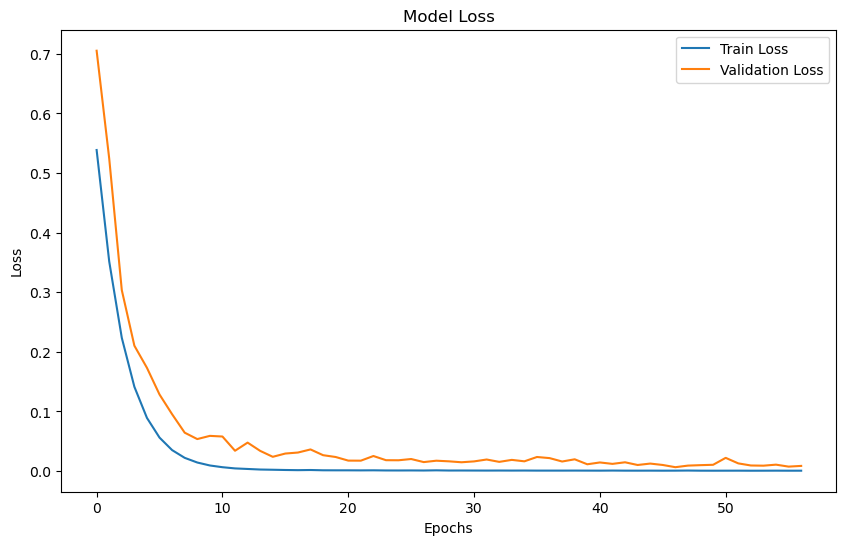

In [112]:
# training & validation loss values as fxn of epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

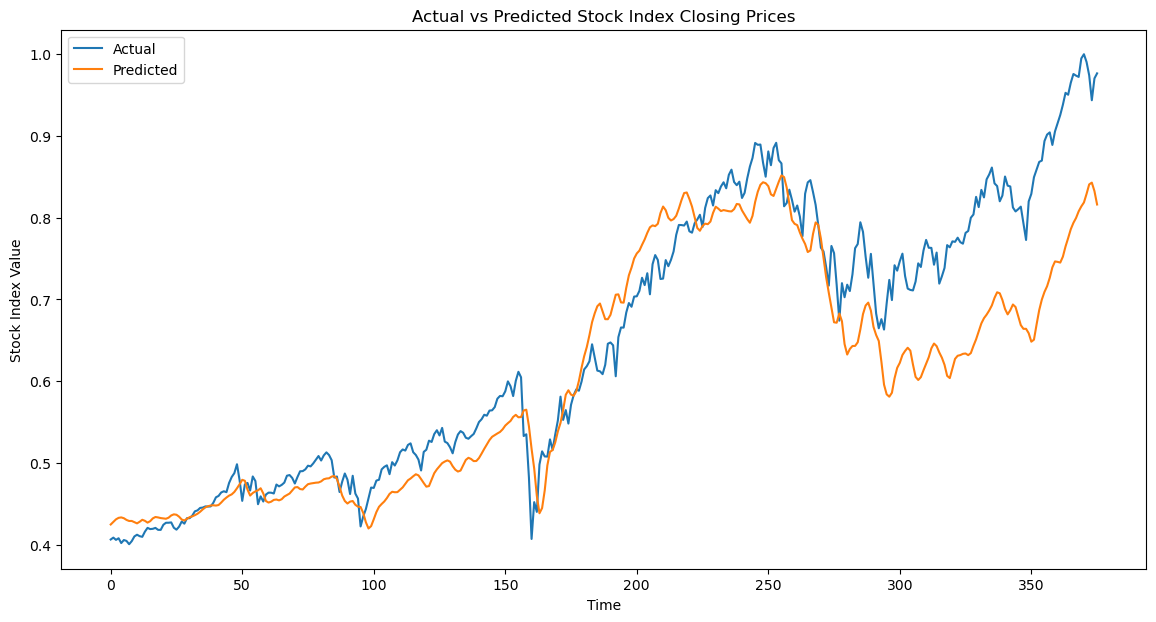

In [113]:
# actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual')
plt.plot(test_predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Index Value')
plt.title('Actual vs Predicted Stock Index Closing Prices')
plt.legend()
plt.show()

In [114]:
from sklearn.model_selection import TimeSeriesSplit

# k-fold
tscv = TimeSeriesSplit(n_splits=5)
cross_val_results = []

for train_index, test_index in tscv.split(X):
    X_train_cv, X_test_cv = X[train_index], X[test_index]
    y_train_cv, y_test_cv = y[train_index], y[test_index]

    # Train model
    model.fit(X_train_cv, y_train_cv, epochs=150, validation_data=(X_test_cv, y_test_cv), callbacks=[early_stopping], verbose=0)

    # Generate predictions
    test_predictions_cv = model.predict(X_test_cv)
    
    # Calculate metrics
    mse_cv = mean_squared_error(y_test_cv, test_predictions_cv)
    rmse_cv = np.sqrt(mse_cv)
    mae_cv = mean_absolute_error(y_test_cv, test_predictions_cv)
    mape_cv = mean_absolute_percentage_error(y_test_cv, test_predictions_cv)
    r2_cv = r2_score(y_test_cv, test_predictions_cv)
    
    cross_val_results.append((mse_cv, rmse_cv, mae_cv, mape_cv, r2_cv))

# Calculate average cross-validation metrics
avg_cross_val_results = np.mean(cross_val_results, axis=0)
print(f'Cross-Validation MSE: {avg_cross_val_results[0]}')
print(f'Cross-Validation RMSE: {avg_cross_val_results[1]}')
print(f'Cross-Validation MAE: {avg_cross_val_results[2]}')
print(f'Cross-Validation MAPE: {avg_cross_val_results[3]}')
print(f'Cross-Validation R2: {avg_cross_val_results[4]}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Cross-Validation MSE: 0.0031796408978387704
Cross-Validation RMSE: 0.0432614902463012
Cross-Validation MAE: 0.0375127000837837
Cross-Validation MAPE: 0.16091175584484405
Cross-Validation R2: 0.5743237209422278


Date
1988-04-10         NaN
1988-04-17   -0.034363
1988-04-24    0.000124
1988-05-01    0.007017
1988-05-08   -0.015360
                ...   
2016-12-25    0.002937
2017-01-01   -0.009513
2017-01-08    0.018097
2017-01-15   -0.000872
2017-01-22    0.000061
Name: _MKT, Length: 1503, dtype: float64
Date
1988-04-10    0.039373
1988-04-17    0.039489
1988-04-24    0.039480
1988-05-01    0.039512
1988-05-08    0.039572
                ...   
2016-12-25    0.419412
2017-01-01    0.420791
2017-01-08    0.420940
2017-01-15    0.421410
2017-01-22    0.422830
Length: 1503, dtype: float32
In-Sample IR: nan


C:\Users\Diana\AppData\Local\Temp\ipykernel_33712\2509977921.py:12: RuntimeWarning: invalid value encountered in scalar divide
  train_ir = (np.mean(train_excess_returns) / np.std(train_excess_returns)) * np.sqrt(252)


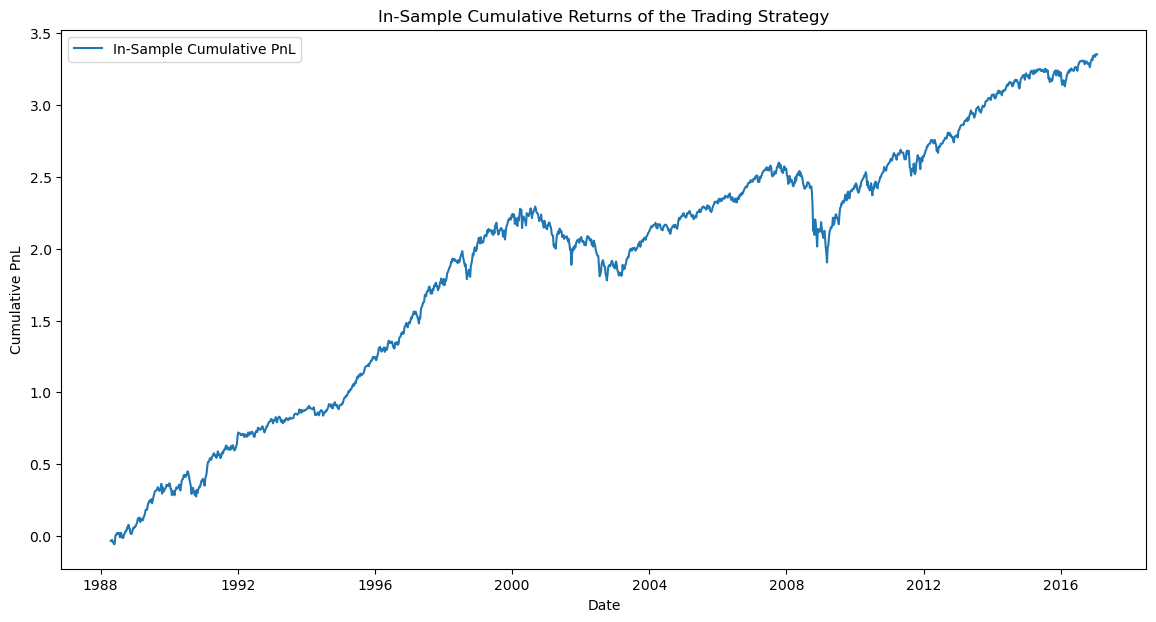

ValueError: Length of values (376) does not match length of index (375)

In [123]:
# Trading Strategy Implementation for In-Sample
train_market_returns = data['_MKT'].iloc[:train_size].pct_change()
print(train_market_returns)
train_predicted_returns = pd.Series(train_predictions.flatten(), index=train_market_returns.index[:len(train_predictions.flatten())])
print(train_predicted_returns)
train_signal = np.where(train_predicted_returns > 0, 1, -1)

# Calculate In-Sample PnL and IR
train_pnl = train_signal[:-1] * train_market_returns[1:]
train_cumulative_pnl = np.cumsum(train_pnl)
train_excess_returns = train_pnl - train_market_returns[1:]
train_ir = (np.mean(train_excess_returns) / np.std(train_excess_returns)) * np.sqrt(252)

print(f'In-Sample IR: {train_ir}')

# Plot In-Sample cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(train_cumulative_pnl, label='In-Sample Cumulative PnL')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.title('In-Sample Cumulative Returns of the Trading Strategy')
plt.legend()
plt.show()

# Trading Strategy Implementation for Out-of-Sample
test_market_returns = data['_MKT'].iloc[train_size+lag:].pct_change().dropna()
test_predicted_returns = pd.Series(test_predictions.flatten(), index=test_market_returns.index)
test_signal = np.where(test_predicted_returns > 0, 1, -1)

# Calculate Out-of-Sample PnL and IR
test_pnl = test_signal[:-1] * test_market_returns[1:]
test_cumulative_pnl = np.cumsum(test_pnl)
test_excess_returns = test_pnl - test_market_returns[1:]
test_ir = (np.mean(test_excess_returns) / np.std(test_excess_returns)) * np.sqrt(252)

print(f'Out-of-Sample IR: {test_ir}')# Trading Strategy Implementation for In-Sample
train_market_returns = data['_MKT'].iloc[:train_size].pct_change().dropna()
train_predicted_returns = pd.Series(train_predictions.flatten(), index=train_market_returns.index[:len(train_predictions.flatten())])
train_signal = np.where(train_predicted_returns > 0, 1, -1)

# Calculate In-Sample PnL and IR
train_pnl = train_signal * train_market_returns[:len(train_signal)]
train_cumulative_pnl = np.cumsum(train_pnl)
train_excess_returns = train_pnl - train_market_returns[:len(train_signal)]
train_ir = (np.mean(train_excess_returns) / np.std(train_excess_returns)) * np.sqrt(252)

print(f'In-Sample IR: {train_ir}')

# Plot In-Sample cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(train_cumulative_pnl, label='In-Sample Cumulative PnL')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.title('In-Sample Cumulative Returns of the Trading Strategy')
plt.legend()
plt.show()

# Trading Strategy Implementation for Out-of-Sample
test_market_returns = data['_MKT'].iloc[train_size:].pct_change().dropna()
test_predicted_returns = pd.Series(test_predictions.flatten(), index=test_market_returns.index[:len(test_predictions.flatten())])
test_signal = np.where(test_predicted_returns > 0, 1, -1)

# Calculate Out-of-Sample PnL and IR
test_pnl = test_signal * test_market_returns[:len(test_signal)]
test_cumulative_pnl = np.cumsum(test_pnl)
test_excess_returns = test_pnl - test_market_returns[:len(test_signal)]
test_ir = (np.mean(test_excess_returns) / np.std(test_excess_returns)) * np.sqrt(252)

print(f'Out-of-Sample IR: {test_ir}')

# Plot Out-of-Sample cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(test_cumulative_pnl, label='Out-of-Sample Cumulative PnL')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.title('Out-of-Sample Cumulative Returns of the Trading Strategy')
plt.legend()
plt.show()


# Plot Out-of-Sample cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(test_cumulative_pnl, label='Out-of-Sample Cumulative PnL')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.title('Out-of-Sample Cumulative Returns of the Trading Strategy')
plt.legend()
plt.show()